In [109]:
import sys
import os
# Local imports
src_dir = os.path.abspath('../')
os.chdir(src_dir)
sys.path.append(src_dir)
from src.config import *

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib

## Funs

In [19]:
def set_notebook_options(matplotlib_params_dct={}, plt_style='fivethirtyeight'):
    # Set matplotlib params
    default_matplotlib_params_dct = {'axes.labelsize': 14,
                                    'xtick.labelsize': 12,
                                    'ytick.labelsize': 12,
                                    'text.color': 'k'}
    matplotlib_params_dct = default_matplotlib_params_dct | matplotlib_params_dct
    for key, value in matplotlib_params_dct.items():
        matplotlib.rcParams[key] = value
    # Plt style
    plt.style.use(plt_style)

In [40]:
class DataLoader:
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir
        self.data = None
        self.loaded_data_dct = {}
    
    def load_data(self, data_file, *args, **kwargs):
        if data_file == 'co2_data':
            self.data = sm.datasets.co2.load_pandas().data
        else:  
            data_path = os.path.join(self.data_dir, data_file)
            self.data = pd.read_csv(data_path, *args, **kwargs)
        
        self.loaded_data_dct[data_file] = self.data

        return self.data

In [42]:
class DataProcessor:
    def __init__(self, data=None):
        self.data = data
    
    def set_dt_index(self, dt_col, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data[dt_col] = pd.to_datetime(data[dt_col])
        data = data.set_index(dt_col)
        data = data.sort_index()
        if inplace:
            self.data = data
        return data
    
    def sort_index(self, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.sort_index()
        if inplace:
            self.data = data
        return data
    
    def rename_dt_index(self, new_name='', data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data.index.names = [new_name]
        if inplace:
            self.data = data
        return data

    def rename_df_columns(self, col_name_map={}, data=None, inplace=False):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.rename(columns=col_name_map)
        if inplace:
            self.data = data
        return data

    def drop(self, data=None, inplace=False, *args, **kwargs):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data.drop(*args, **kwargs)
        if inplace:
            self.data = data
        return data
    
    def select_columns(self, columns=[], data=None, inplace=False, *args, **kwargs):
        data = self.data if data is None else data
        if data is None:
            raise ValueError('No data provided!')
        if not inplace:
            data = data.copy()
        data = data[columns]
        if inplace:
            self.data = data
        return data

    def preprocess_data(self):
        pass

## CO2 Data

In [53]:
df = DataLoader().load_data('co2_data')
dp = DataProcessor(df)
dp.sort_index(inplace=False)
dp.rename_dt_index('dt', inplace=True)
dp.rename_df_columns({'co2': 'y'}, inplace=True)
co2_df = dp.data

In [70]:
# The 'MS' string groups the data in buckets by start of the month
co2_df = dp.set_dt_index('dt', data=co2_df.resample('MS').mean().reset_index())
# The term bfill means that we use the value before filling in missing values
co2_df = co2_df.fillna(co2_df.bfill())

In [116]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
import itertools
from datetime import datetime

In [123]:
train_size = 0.8
split_year_str = str(co2_df.index.year.unique()[int(co2_df.index.year.nunique() * train_size)])
split_date_dt = pd.to_datetime(datetime.strptime(split_year_str, '%Y').date())

train = co2_df.loc[co2_df.index < split_date_dt]
test = co2_df.loc[co2_df.index >= split_date_dt]

In [91]:
import warnings
import itertools

# Define the parameter grids
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s_values = [12]

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

tscv = TimeSeriesSplit(n_splits=5)

c:\Users\dmika\anaconda3\envs\tsenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [132]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=param_grid[10][:3],
                                seasonal_order=param_grid[10][3:],
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq='MS')

c:\Users\dmika\anaconda3\envs\tsenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [145]:
y_pred = mod.fit().get_prediction(start=pd.to_datetime('1993-01-01'), end=pd.to_datetime('2001-12-01'), dynamic=False).predicted_mean
y_pred.index.name = 'dt'
y_pred = dp.set_dt_index('dt', data=y_pred.reset_index())

In [147]:
mean_squared_error(test['y'], y_pred['predicted_mean'])

1.7055924943414298

In [135]:
test

,y
dt,
1993-01-01,356.680
1993-02-01,357.175
1993-03-01,358.425
1993-04-01,359.325
1993-05-01,360.180
...,...
2001-08-01,369.425
2001-09-01,367.880
2001-10-01,368.050


In [122]:
train_size = 0.8
split_year_str = str(co2_df.index.year.unique()[int(co2_df.index.year.nunique() * train_size)])
split_date_dt = pd.to_datetime(datetime.strptime(split_year_str, '%Y').date())

In [121]:
pd.to_datetime(datetime.strptime(split_year_str, '%Y').date())

Timestamp('1993-01-01 00:00:00')

In [113]:
pd.to_datetime(co2_df.index.year.unique()[int(co2_df.index.year.nunique() * 0.8)])

Timestamp('1970-01-01 00:00:00.000001993')

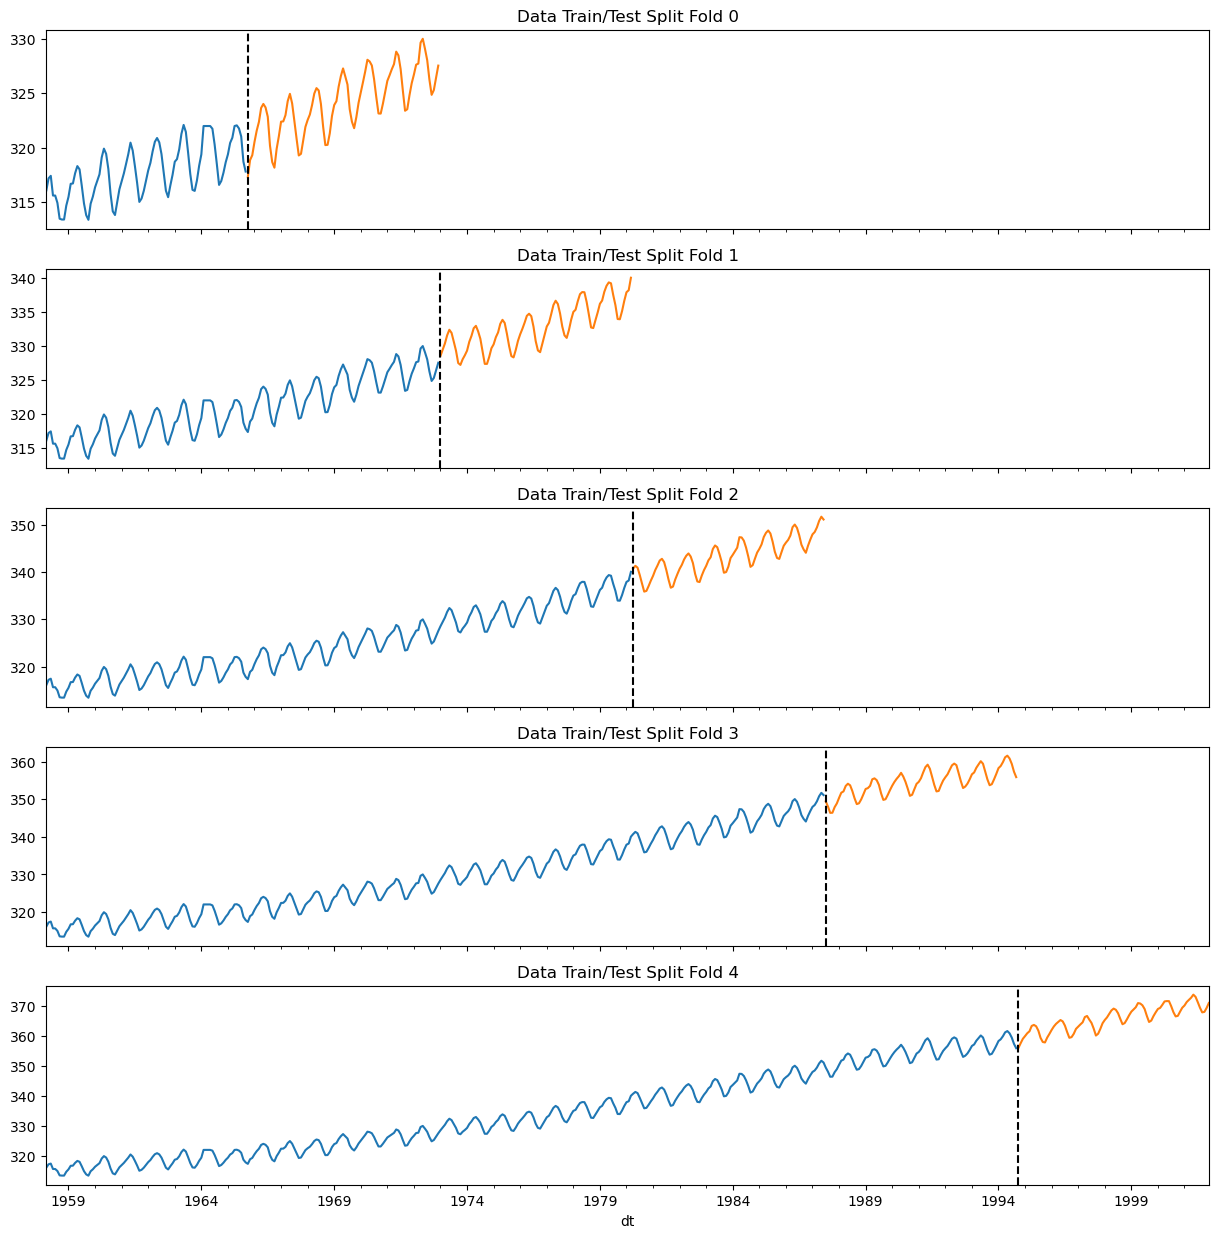

In [83]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tscv.split(co2_df):
    train = co2_df.iloc[train_idx]
    test = co2_df.iloc[val_idx]
    train['y'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['y'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [71]:
import warnings
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
seasonal_pdq

## AEMW

In [ ]:
dl = DataLoader()
df = dl.load_data('AEP_hourly.csv')
dp = DataProcessor()
dp = DataProcessor(df)
dp.set_dt_index('Datetime', inplace=True)
dp.rename_dt_index('dt', inplace=True)
dp.rename_df_columns({'AEP_MW': 'y'}, inplace=True)

## Superstore

In [36]:
dl = DataLoader()
df = dl.load_data('superstore_data.csv')
dp = DataProcessor()
dp = DataProcessor(df)
dp.set_dt_index('Order Date', inplace=True)
dp.rename_dt_index('dt', inplace=True)
dp.select_columns(['Sales'], inplace=True)
dp.rename_df_columns(col_name_map={'Sales': 'y'}, inplace=True)
df = dp.data